## Plots to compare the scoreing metrics 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from glob import glob
import re
from scipy.stats import mannwhitneyu

# Set default configuration for all plots
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
plt.figsize = (2,2)    

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
def melt_score_df(score_df, id_vars=['GO', 'Gene_Count']):
    columns_score = [col for col in score_df.columns if col.endswith('Score')]
    filtered_score_df = score_df[id_vars + columns_score]
    long_scores = filtered_score_df.melt(id_vars=id_vars, var_name='Score Type', value_name='Score')
    
    # Map the original score type names to the desired ones
    def map_score_type(score_type):
        if 'default' in score_type:
            return 'Real'
        elif '50perc_contaminated' in score_type:
            return '50/50 Mix'
        elif '100perc_contaminated' in score_type:
            return 'Random'
        else:
            return score_type
    
    # Apply the mapping
    long_scores['Score Type'] = long_scores['Score Type'].apply(map_score_type)
    
    # Remove unwanted symbols and return float
    long_scores.Score = long_scores.Score.apply(lambda x: float(re.sub("[^0-9.-]", "", x)) if isinstance(x, str) else x)
    
    return long_scores

def calculate_p_values(score_data):
    p_values = {}
    unique_score_types = score_data['Score Type'].unique()
    # for each type of score, compare it to all other types
    for i, type1 in enumerate(unique_score_types):
        for j, type2 in enumerate(unique_score_types):
            if i < j:
                data1 = score_data[score_data['Score Type'] == type1]['Score']
                data2 = score_data[score_data['Score Type'] == type2]['Score']
                _, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
                p_values[(type1, type2)] = p_val
    return p_values


In [6]:

result_files = glob('./data/GO_term_analysis/model_compare/LLM_processed*100set*.tsv')
# add on data to the LLM processed data based on column names 
print(result_files)

['./data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_gpt_4.tsv', './data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_gemini_pro.tsv', './data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_mixtral_instruct.tsv', './data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_llama2_70b.tsv', './data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_gpt_35.tsv']


In [13]:

# Define the color scheme for different score types
score_type_colors = {
    'Real': 'steelblue',
    '50/50 Mix': 'orange',
    'Random': 'green'
}
def plot_score_histogram(score_data, model_name, axs, bins, max_y = 80, show_legend=False):
    score_types = ['Real', '50/50 Mix', 'Random']

    for idx, score_type in enumerate(score_types):
        ax = axs[idx]
        color = score_type_colors.get(score_type, 'black')
        sns.histplot(data=score_data[score_data['Score Type'] == score_type], x='Score', bins=bins, color=color, ax=ax, kde=False)

        median_score = score_data[score_data['Score Type'] == score_type]['Score'].median()
        no_zero_score = score_data[score_data['Score Type'] == score_type]['Score'][score_data[score_data['Score Type'] == score_type]['Score'] != 0]
        std_score = no_zero_score.std()

        # print(f'{model_name} - {score_type} Median: {median_score}')
        # print(f'{model_name} - {score_type} Std: {median_score - std_score} to {median_score + std_score}')

        # Add vertical lines for median
        ax.axvline(median_score, color=color, linestyle='--', linewidth=1)
        ax.set_xlim(-0.05, 1)
        ax.set_ylim(0, max_y)
    
        ax.set_xlabel('')
        
        ax.set_ylabel('')
        if idx == 0:
            ax.set_title(model_name)
        if idx == 2:
            sns.despine(ax=ax)
        else:
            sns.despine(ax=ax, bottom=True)
            # not show x ticks and axis
            ax.xaxis.set_visible(False)
            
    plt.tight_layout(h_pad=0.02)

def plot_all_models_histogram(models_data, save_fig=None):
    num_models = len(models_data)
    num_score_types = len(score_type_colors)

    # Determine the bin edges
    bins = np.linspace(-0.05, 1, 41)  # 40 bins between -0.05 and 1

    # Determine the maximum y limit across all data for uniformity
    max_y = 0
    for score_data in models_data.values():
        for score_type in score_data['Score Type'].unique():
            count = np.histogram(score_data[score_data['Score Type'] == score_type]['Score'], bins=bins)[0].max()
            if count > max_y:
                max_y = count
    
    fig, axs = plt.subplots(num_score_types, num_models, figsize=(7, 1 * num_score_types), sharey=True, sharex=True)
    
    for i, (model_name, score_data) in enumerate(models_data.items()):
        plot_score_histogram(score_data, model_name, axs[:, i], bins, max_y, show_legend=(i == 0))
 
    axs[1, 0].set_ylabel('Number of gene sets') 
    axs[2, 2].set_xlabel('Raw confidence Score')       

    if save_fig:
        plt.savefig(f'{save_fig}.svg', bbox_inches='tight')
    plt.tight_layout(w_pad=0.02)
    plt.show()

## We find the confidence scores show clear bins, so we set confidence levels to categorize the score

In [15]:
# only collect gpt4 scores
scores_gpt = []

gpt_df = pd.read_csv('./data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_gpt_4.tsv', sep='\t')
long_scores = melt_score_df(gpt_df)

scores_gpt.extend(long_scores['Score'])


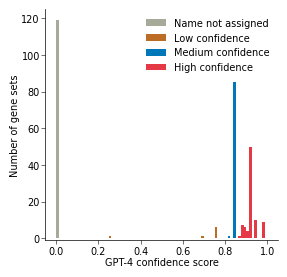

In [16]:
# Create the figure and axis
plt.figure(figsize=(3,3))
# Create histograms for each region
bins = np.linspace(0, 1, 81)  # Define bins
scores_gpt = np.array(scores_gpt)

# Histplot for 'Name not assigned'
sns.histplot(scores_gpt[(scores_gpt >= 0) & (scores_gpt < 0.03)], bins=bins, color='#A5AA99',  linewidth=0, alpha=1, kde=False)
# Histplot for 'Low confidence'
sns.histplot(scores_gpt[(scores_gpt >= 0.03) & (scores_gpt < 0.82)], bins=bins, color='#bc6c25', linewidth=0, alpha=1, kde=False)
# Histplot for 'Medium confidence'
sns.histplot(scores_gpt[(scores_gpt >= 0.82) & (scores_gpt < 0.87)], bins=bins, color='#0077b6', linewidth=0, alpha=1, kde=False)
# Histplot for 'High confidence'
sns.histplot(scores_gpt[(scores_gpt >= 0.87) & (scores_gpt <= 1)], bins=bins, color='#e63946', linewidth=0, alpha=1, kde=False)

# Add vertical lines
# plt.axvline(0.87, color='black', linestyle='--', linewidth=0.7, alpha=0.8)
# plt.axvline(0.82, color='black', linestyle='--', linewidth=0.7, alpha=0.8)

# Add labels and despine
plt.xlabel('GPT-4 confidence score')
plt.ylabel('Number of gene sets')
plt.ylim(-1, 125)
sns.despine()
plt.legend(['Name not assigned', 'Low confidence', 'Medium confidence', 'High confidence'], loc='upper right')

plt.savefig('./figures/model_compare/gpt4_confidence_score_histogram_colors.svg', bbox_inches='tight')
# Show plot
plt.show()

## Manual review of the confidence score 

seleted 27 gene sets from the copus with 0.92, and 0.85 scores. 

delete the confidence score, and any description with confidence. Allow the human reviewer to score the confidence. 

* selection and manual review is done in google doc 

In [3]:
import pandas as pd
file_path = 'data/GO_term_analysis/Blinded survey on confidence score.xlsx'
# Load the sheets into DataFrames
df= pd.read_excel(file_path, sheet_name='confidence_eval')
# update the Reviewer's score bin (High, Medium) to capital case
df['Reviewer\'s score bin'] = df["Reviewer\'s score bin (High, Medium)"].str.capitalize()
# randomly pick 25, just make the gene set number less random
df = df.sample(25)

df.head()

,GO,Genes,Gene_Count,LLM Name,LLM Analysis (removing confidence),"Reviewer's score bin (High, Medium)",Raw score,NOTES,Reviewer's score bin
2,GO:1902083,NCOA7 ATP2B4 SNTA1 OXR1 DMD TBC1D24,6,Cellular Ion Homeostasis and Oxidative Stress ...,"1. NCOA7, or Nuclear Receptor Coactivator 7, i...",Medium,0.85,NaN,Medium
14,GO:0002792,ADRA2A KCNB1 SFRP1 IRS1 GHSR CRH LEP CD74 PFKL...,46,Metabolic Regulation and Energy Homeostasis,"1. Several proteins in this system, such as AD...",high,0.85,NaN,High
5,GO:0070202,CCT8 CCT5 CCT2 DKC1 CCT4 TERF1 CCT6A TCP1 SPID...,12,Chaperonin-mediated Protein Folding and Telome...,1. The CCT (chaperonin containing TCP1) comple...,High,0.92,Each of the two processes are well supported. ...,High
24,GO:0003357,PHOX2A PHOX2B RNF220 SOX11 EDNRA EDN1 ASCL1 SO...,11,Neurogenesis and Neural Crest Development,1. PHOX2A and PHOX2B are homeodomain-containin...,high,0.92,NaN,High
3,GO:0014744,PPP3CA MYMK FOXO3 MYOG TRPC3,5,Muscle differentiation and calcium signaling,"1. PPP3CA, also known as calcineurin A alpha, ...",High,0.85,NaN,High


In [6]:
df.to_csv('data/GO_term_analysis/confidence_eval_25_sample_with_human_review.tsv', sep='\t', index=False)

In [4]:
# create the contingency table

contingency_table = pd.crosstab(df["Reviewer's score bin"], df['Raw score'])

# Rename the columns and index for clarity
contingency_table = contingency_table.rename(index={
    'High': 'Human High',
    'Medium': 'Human Medium'
}, columns={
    
    0.92: 'GPT-4 High (0.92)', 
    0.85: 'GPT-4 Medium (0.85)'
})
contingency_table = contingency_table[['GPT-4 High (0.92)', 'GPT-4 Medium (0.85)']]

contingency_table

Raw score,GPT-4 High (0.92),GPT-4 Medium (0.85)
Reviewer's score bin,,
Human High,10,6
Human Medium,1,8


In [5]:
# run the fisher exact test
from scipy import stats

oddsratio, p_value = stats.fisher_exact(contingency_table)

oddsratio, p_value

(13.333333333333334, 0.03300578812760802)

### Combine all the model confidence scores and bin them 

In [18]:
combine_df = pd.DataFrame()
for file in result_files:
    df = pd.read_csv(file, sep='\t')
    long_scores = melt_score_df(df)
    
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    print(model_name)

    # map the model name to my own choice of names
    long_scores['Model'] = model_name
    combine_df = pd.concat([combine_df, long_scores])
combine_df['Score Bin'] = pd.cut(combine_df['Score'], bins=[-np.inf, 0, 0.81, 0.86, np.inf], labels=['Name not assigned', 'Low confidence', 'Medium confidence', 'High confidence'])

new_model_name = {'gpt_4': 'GPT-4', 'gemini_pro': 'Gemini Pro','gpt_35':'GPT-3.5', 'mixtral_instruct': 'Mixtral Instruct', 'llama2_70b': 'Llama2 70b'}
combine_df['Model'] = combine_df['Model'].map(new_model_name)

# combine_df

combine_df.to_csv('./data/GO_term_analysis/model_compare/combined_scores_df.tsv', sep='\t', index=False)

gpt_4
gemini_pro
mixtral_instruct
llama2_70b
gpt_35


,GO,Gene_Count,Score Type,Score,Model,Score Bin
0,GO:0014744,5,Real,0.85,GPT-4,Medium confidence
1,GO:0000338,11,Real,0.98,GPT-4,High confidence
2,GO:0060696,7,Real,0.92,GPT-4,High confidence
3,GO:0019885,22,Real,0.98,GPT-4,High confidence
4,GO:0003166,6,Real,0.95,GPT-4,High confidence
...,...,...,...,...,...,...
295,GO:1900368,25,Random,0.85,GPT-3.5,Medium confidence
296,GO:2000524,3,Random,0.85,GPT-3.5,Medium confidence
297,GO:2000556,8,Random,0.85,GPT-3.5,Medium confidence
298,GO:0120253,3,Random,0.85,GPT-3.5,Medium confidence


In [31]:
print(combine_df['Model'].unique())

['GPT_3.5' 'GPT-4' 'Llama2 70b' 'Mixtral Instruct' 'Gemini Pro']


## Plot the confidence score bins with functional enrichment result 

In [11]:
## check the go term enrichment analysis result 
import pandas as pd
enrichr_res = pd.read_csv('./data/GO_term_analysis/100_GO_terms_gprofiler_res.tsv', sep='\t')
genes_col = [col for col in enrichr_res.columns if col.endswith('Genes')]
# create the count table

p_cutoff = 0.05
count_table = pd.DataFrame(columns=['Gene set type','Unassigned GO terms', 'Assigned GO terms'])

for col in genes_col: 
    num_enriched = sum(enrichr_res[f'{col} adj p-value'] <= p_cutoff)
    num_unassigned = sum(enrichr_res[f'{col} adj p-value'] > p_cutoff)
    count_row = pd.DataFrame({'Gene set type': col, 'Unassigned GO terms': num_unassigned, 'Assigned GO terms': num_enriched}, index=[0])
    count_table = pd.concat([count_table, count_row], ignore_index=True)

count_table


,Gene set type,Unassigned GO terms,Assigned GO terms
0,Genes,0,100
1,50perc_contaminated_Genes,1,99
2,100perc_contaminated_Genes,73,27


In [12]:
#for enrich result, check the size of the gene sets and number of significant terms for the 100perc_contaminated_Genes
random_named = enrichr_res.loc[~enrichr_res['100perc_contaminated_Genes enriched term id'].isna(), :]

# describe the size 
random_named.loc[random_named['Gene_Count']<= 5, '100perc_contaminated_Genes overlap size']

0     1.0
11    1.0
19    1.0
26    1.0
28    1.0
34    1.0
45    2.0
55    1.0
64    1.0
72    1.0
78    1.0
96    1.0
98    2.0
Name: 100perc_contaminated_Genes overlap size, dtype: float64

In [13]:
from scipy.stats import chi2_contingency

chi_square_results = pd.DataFrame(columns=['Gene set type A', 'Gene set type B', 'Chi-Square Statistic', 'Chi-Square p-value'])

# Perform chi-square tests between each combination of gene set types
for i in range(len(count_table)):
    for j in range(i+1, len(count_table)):
        # Create the contingency table for the current pair of gene set types
        contingency_table = count_table.iloc[[i, j], 1:3].values
        
        # Perform the chi-square test
        chi2_stat, p_value, dof, _ = chi2_contingency(contingency_table)
        
        # Append the results to the results DataFrame
        result = pd.DataFrame({
            'Gene set type A': [count_table['Gene set type'][i]],
            'Gene set type B': [count_table['Gene set type'][j]],
            'Chi-Square Statistic': [chi2_stat],
            'Chi-Square p-value': [p_value]
        }, index=[0]) 
        chi_square_results = pd.concat([chi_square_results, result], ignore_index=True)

chi_square_results

,Gene set type A,Gene set type B,Chi-Square Statistic,Chi-Square p-value
0,Genes,50perc_contaminated_Genes,0.000000,1.000000e+00
1,Genes,100perc_contaminated_Genes,111.832596,3.887907e-26
2,50perc_contaminated_Genes,100perc_contaminated_Genes,108.129558,2.517706e-25


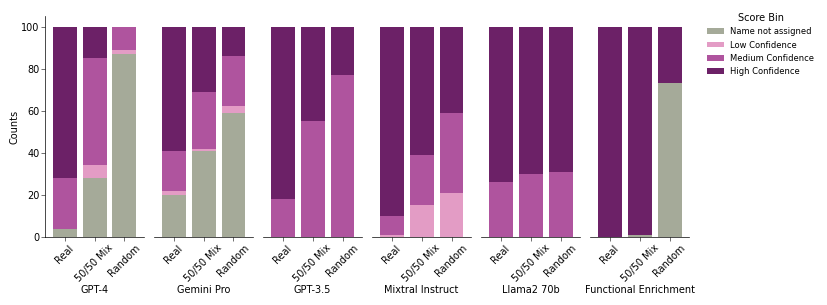

In [14]:
# Defining the custom order for Score Types and Models
score_type_order = ['Real', '50/50 Mix', 'Random']
model_order = ['GPT-4', 'Gemini Pro', 'GPT-3.5', 'Mixtral Instruct', 'Llama2 70b']
score_bin_order =[ 'Name not assigned', 'Low Confidence', 'Medium Confidence', 'High Confidence']
color_palette = ['#A5AA99','#e39cc5','#af549e', '#6c2167']

combine_df = pd.read_csv('./data/GO_term_analysis/model_compare/combined_scores_df.tsv', sep='\t')
# Creating a categorical type for ordering
combine_df['Score Type'] = pd.Categorical(combine_df['Score Type'], categories=score_type_order, ordered=True)
combine_df['Model'] = pd.Categorical(combine_df['Model'], categories=model_order, ordered=True)
combine_df['Score Bin'] = pd.Categorical(combine_df['Score Bin'], categories=score_bin_order, ordered=True)

# Grouping and stacking data 
stacked_bins_data_option2 = combine_df.groupby(['Model', 'Score Type', 'Score Bin']).size().unstack().fillna(0)

# Modify the layout to include an additional subplot
fig, axes = plt.subplots(1, len(model_order) + 1, figsize=(7,3), sharey=True)

# Plotting for each model (existing code)
for i, model in enumerate(model_order):
    model_data = stacked_bins_data_option2.loc[model]
    model_data.plot(kind='bar', stacked=True, ax=axes[i], width=0.8, legend=False, color=color_palette)
    axes[i].set_xlabel(model)
    axes[i].set_xticklabels(['Real', '50/50 Mix', 'Random'], rotation=45)
    if i == 0:
        axes[i].set_ylabel('Counts')
    else:
        axes[i].yaxis.set_visible(False)

# Plotting the new stacked bar plot
count_table.plot(kind='bar', stacked=True, ax=axes[-1], x='Gene set type',y=['Unassigned GO terms', 'Assigned GO terms'], color=['#A5AA99','#6c2167'], width=0.8, legend=False)
axes[-1].set_xticklabels(['Real', '50/50 Mix', 'Random'], rotation=45)
axes[-1].set_xlabel('Functional Enrichment')
axes[-1].yaxis.set_visible(False)

# Adjusting the layout for the new plot
for i, ax in enumerate(axes):
    if i != 0:
        sns.despine(ax=ax, left=True)
    else:
        sns.despine(ax=ax)
        
plt.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels, title='Score Bin', loc='upper left', bbox_to_anchor=(1, 1), fontsize=6)
plt.tight_layout(h_pad=0.01)
# Saving the figure
plt.savefig('./figures/model_compare/combined_scores_bin_counts_by_models_with_gprofiler.svg', bbox_inches='tight')
plt.show()


### Calculate significance

In [1]:
import pandas as pd
data = pd.read_csv('./data/GO_term_analysis/model_compare/combined_scores_df.tsv', sep='\t')

In [3]:
data['Score Type'].unique()

array(['Real', '50/50 Mix', 'Random'], dtype=object)

In [4]:
import numpy as np
from scipy.stats import chi2_contingency


# Initialize a new results list to store the pairwise chi-square test results
pairwise_results = []

# Iterate over each model
for model in data['Model'].unique():
    model_data = data[data['Model'] == model]
    
    # Define the pairs for comparison
    comparison_pairs = [
        ('Real', '50/50 Mix'),  # Real vs contaminated
        ('Real', 'Random'),     # Real vs Random
        ('50/50 Mix', 'Random') # contaminated vs Random
    ]

    # Perform chi-square test for each pair
    for pair in comparison_pairs:
        # Creating a subset of data for the two score types being compared
        pair_data = model_data[model_data['Score Type'].isin(pair)]
        
        # Constructing the contingency table for 'Score Bin' across the selected 'Score Type'
        score_bin_table = pd.crosstab(pair_data['Score Bin'], pair_data['Score Type'])
        
        # If the table is valid, perform chi-square test, else skip
        if score_bin_table.shape[1] == 2:  # Ensure table is correct shape for comparison
            chi2, p, dof, expected = chi2_contingency(score_bin_table)
            pairwise_results.append({
                'Model': model,
                'Comparison': f"{pair[0]} vs {pair[1]}",
                'Chi-Square Statistic': chi2,
                'Chi-Square p-value': p
            })
        else:
            # Handle cases where the contingency table is not suitable for chi-square test
            pairwise_results.append({
                'Model': model,
                'Comparison': f"{pair[0]} vs {pair[1]}",
                'Chi-Square Statistic': np.nan,
                'Chi-Square p-value': np.nan
            })

# Convert the results to a DataFrame for better presentation
pairwise_results_df = pd.DataFrame(pairwise_results)
pairwise_results_df


,Model,Comparison,Chi-Square Statistic,Chi-Square p-value
0,GPT-4,Real vs 50/50 Mix,71.064828,2.524779e-15
1,GPT-4,Real vs Random,154.531868,2.773728e-33
2,GPT-4,50/50 Mix vs Random,73.076017,9.362626e-16
3,Gemini Pro,Real vs 50/50 Mix,17.665257,5.155977e-04
4,Gemini Pro,Real vs Random,47.774286,2.378503e-10
5,Gemini Pro,50/50 Mix vs Random,10.838693,1.263088e-02
6,Mixtral Instruct,Real vs 50/50 Mix,24.637718,4.466707e-06
7,Mixtral Instruct,Real vs Random,54.403679,1.536000e-12
8,Mixtral Instruct,50/50 Mix vs Random,8.082859,1.757234e-02
9,Llama2 70b,Real vs 50/50 Mix,0.223214,6.366016e-01


In [4]:
from glob import glob
import pandas as pd
import numpy as np
files = glob('./data/GO_term_analysis/model_compare/LLM_processed*100set*.tsv')


In [5]:
def bin_scores(df, score_col, prefix):
    # bin scores into no score, low score, medium score, high score
    bins = [-np.inf, 0, 0.81, 0.86, np.inf] # 0 is no score (name not assigned), between 0 to 0.79 is low score, between 0.82 to 0.86 is medium score, above 0.87 is high score
    labels = ['Name not assigned', 'Low Confidence', 'Medium Confidence', 'High Confidence']  # Define the corresponding labels

    # Apply the binning to the 'Score' column
    df[f'{prefix} Score Bin'] = pd.cut(df[score_col], bins=bins, labels=labels)

for file in files:
    model = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    print(model)
    df = pd.read_csv(file, sep='\t')
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    # print(model_name)
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
    
    score_cols = [col for col in df.columns if col.endswith('Score')]
    for col in score_cols:
        long_prefix = col.split(' ')[0]
        print(long_prefix)
        bin_scores(df, col, long_prefix)
    df.to_csv(file, sep='\t', index=False)


gpt_4
gpt_4_default
gpt_4_50perc_contaminated
gpt_4_100perc_contaminated
gemini_pro
gemini_pro_default
gemini_pro_50perc_contaminated
gemini_pro_100perc_contaminated
mixtral_instruct
mixtral_instruct_default
mixtral_instruct_50perc_contaminated
mixtral_instruct_100perc_contaminated
llama2_70b
llama2_70b_default
llama2_70b_50perc_contaminated
llama2_70b_100perc_contaminated
gpt_35
gpt_3.5_default
gpt_3.5_50perc_contaminated
gpt_3.5_100perc_contaminated
